In [1]:

# AKAZE (Accelerated KAZE) + Brute-Force Matcher with Hamming Distance。AKAZE 是一种高效的特征提取算法，它生成的描述符是二进制的，适合使用 Hamming 距离进行匹配

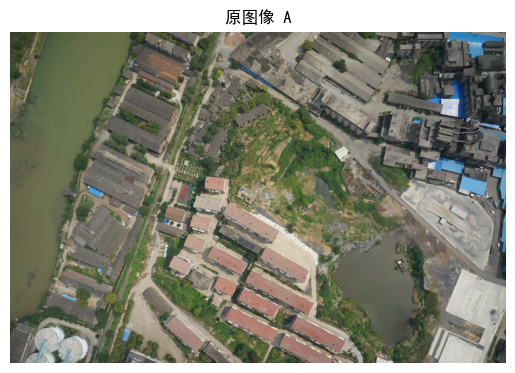

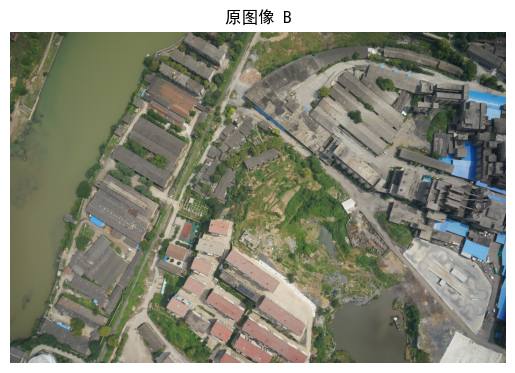

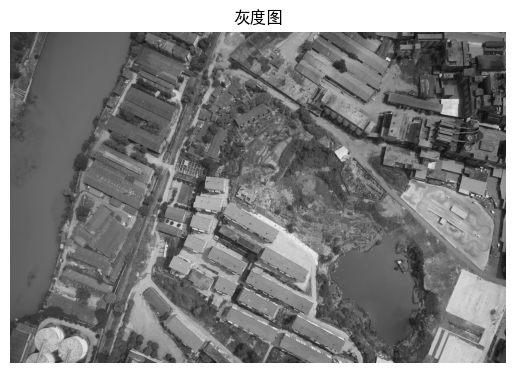

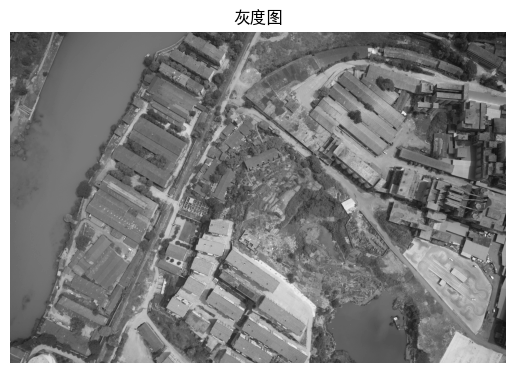

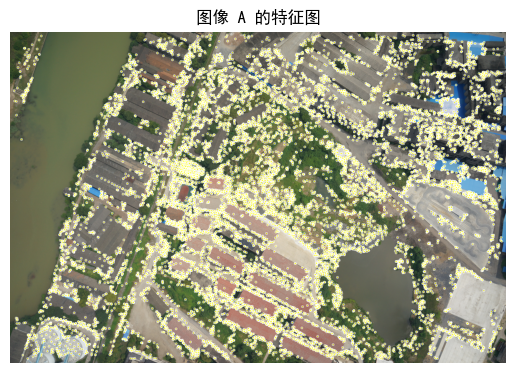

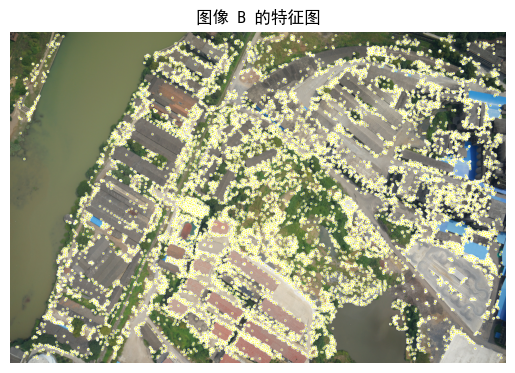

使用 BFMatcher_AKAZE 匹配的匹配点数量：5523


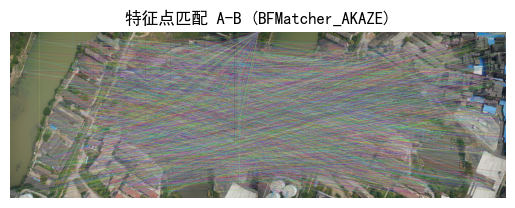

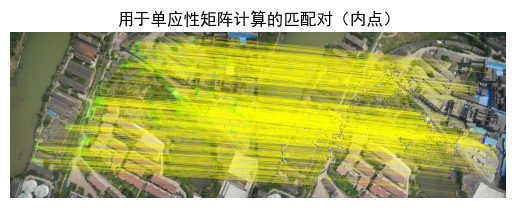

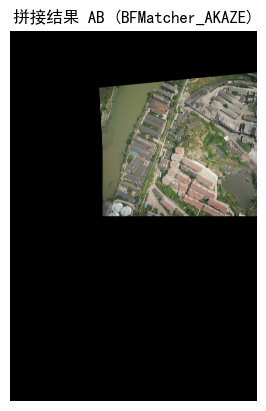

拼接结果已保存至: ./output_BFMatcher_AKAZE/stitched_209_210.jpg


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置全局字体
plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体

# 对于windows系统，如果上面的设置不生效，可以尝试下面的设置
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============================
# 配置参数
# ============================

imageA_path = "./dataset/yongzhou/DSC03209.JPG"  # 图像 A 的路径
imageB_path = "./dataset/yongzhou/DSC03210.JPG"  # 图像 B 的路径

# 匹配参数
distance_ratio = 0.5       # Lowe 的比率测试中的距离比
ransac_threshold = 5        # RANSAC 阈值
min_matches_required = 4    # 计算单应性矩阵所需的最小匹配点数量

# ============================
# 函数定义
# ============================

def show_image(image, title="Image"):
    """
    显示图像的辅助函数，支持彩色和灰度图显示
    """
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image):
    """
    使用 AKAZE 进行特征点检测和描述
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    show_image(gray, "灰度图")

    # 使用 AKAZE 提取特征
    descriptor = cv2.AKAZE_create()
    kps, des = descriptor.detectAndCompute(gray, None)
    kps_float = np.float32([kp.pt for kp in kps])
    return kps, kps_float, des

def match_keypoints_with_akaze(desA, desB):
    """
    使用 BFMatcher 和 Hamming 距离进行 AKAZE 特征匹配，并应用 Lowe 的比率测试筛选优秀匹配点
    """
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    raw_matches = matcher.knnMatch(desA, desB, 2)

    # 应用 Lowe 的比率测试
    good_matches = []
    matches = []
    for m, n in raw_matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))

    return good_matches, matches

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    绘制两个图像之间的匹配结果
    """
    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return vis

def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches):
    """
    利用匹配点计算单应性矩阵并进行图像拼接
    """
    if len(matches) > min_matches_required:
        pts_center = np.float32([center_kps_float[i] for (i, _) in matches])
        pts_align = np.float32([align_kps_float[i] for (_, i) in matches])

        # 使用 RANSAC 计算单应性矩阵
        H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        # 提取内点
        inlier_pts_center = pts_center[status.ravel() == 1]
        inlier_pts_align = pts_align[status.ravel() == 1]

        # 创建合并的图像用于显示
        combined_image = np.hstack((center_image, align_image))
        offset = center_image.shape[1]

        # 绘制匹配对
        for pt_center, pt_align in zip(inlier_pts_center, inlier_pts_align):
            pt_center = (int(pt_center[0]), int(pt_center[1]))
            pt_align = (int(pt_align[0] + offset), int(pt_align[1]))
            cv2.circle(combined_image, pt_center, 5, (0, 255, 0), -1)  # 中心图像的点（绿色）
            cv2.circle(combined_image, pt_align, 5, (255, 0, 0), -1)   # 对齐图像的点（蓝色）
            cv2.line(combined_image, pt_center, pt_align, (0, 255, 255), 1)  # 连接线

        show_image(combined_image, "用于单应性矩阵计算的匹配对（内点）")

        # 拼接图像
        height_center, width_center = center_image.shape[:2]
        canvas_size = (height_center * 2, width_center * 2)
        translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]], dtype=np.float32)

        result = cv2.warpPerspective(center_image, H_translation, canvas_size)
        H_combined = H_translation @ H
        warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)
        result = np.maximum(result, warped_align)

        return result
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None

def show_keypoints(image, keypoints, title="Keypoints"):
    """
    显示特征点，并使用亮色和较大尺寸的圆圈标注特征点位置
    """
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 8, (255, 255, 255), 2)  # 外圈白色
        cv2.circle(image_with_keypoints, (x, y), 4, (0, 255, 255), -1)   # 内圈亮黄色
    show_image(image_with_keypoints, title)

# 加载图像并执行拼接
imageA = cv2.imread(imageA_path)
imageB = cv2.imread(imageB_path)

# 确保图像加载成功
if imageA is None or imageB is None:
    print("Error: Could not load one or both images.")
else:
    show_image(imageA, '原图像 A')
    show_image(imageB, '原图像 B')

    # 提取并显示特征点
    kpsA, kps_floatA, desA = detectAndDescribe(imageA)
    kpsB, kps_floatB, desB = detectAndDescribe(imageB)

    # 显示特征点
    show_keypoints(imageA, kpsA, '图像 A 的特征图')
    show_keypoints(imageB, kpsB, '图像 B 的特征图')

    # 使用 BFMatcher + AKAZE 特征匹配
    good_matches_AB, matches_AB = match_keypoints_with_akaze(desA, desB)
    print(f"使用 BFMatcher_AKAZE 匹配的匹配点数量：{len(good_matches_AB)}")

    # 显示匹配结果
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    if vis_AB is not None:
        show_image(vis_AB, '特征点匹配 A-B (BFMatcher_AKAZE)')

    # 图像拼接
    stitchedAB = stitch_images(imageA, imageB, kps_floatA, kps_floatB,
                               matches_AB)
    if stitchedAB is not None:
        show_image(stitchedAB, '拼接结果 AB (BFMatcher_AKAZE)')

        # 保存拼接结果
        baseA = os.path.basename(imageA_path)[-7:-4]
        baseB = os.path.basename(imageB_path)[-7:-4]
        output_filename = f"./output_BFMatcher_AKAZE/stitched_{baseA}_{baseB}.jpg"
        os.makedirs('./output_BFMatcher_AKAZE', exist_ok=True)
        cv2.imwrite(output_filename, stitchedAB)
        print(f"拼接结果已保存至: {output_filename}")
    else:
        print("由于匹配点不足，拼接失败。")
